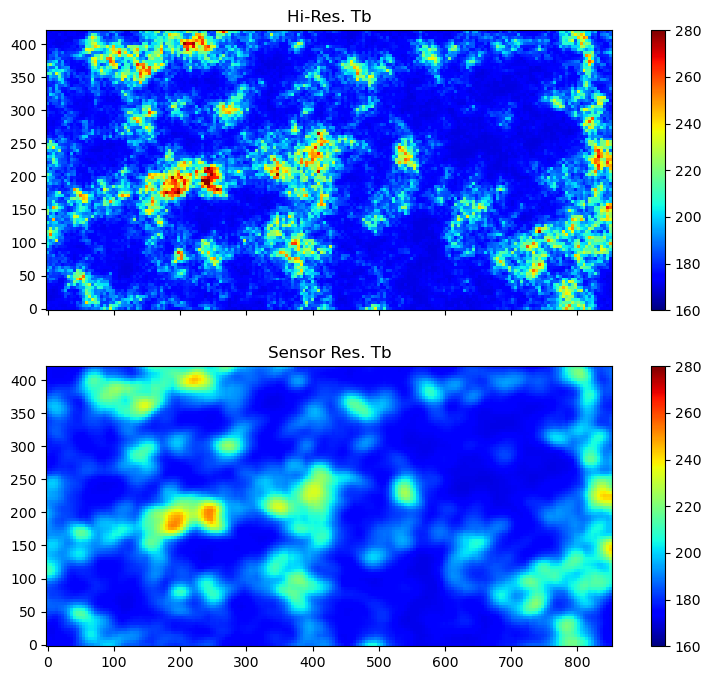

In [13]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from gstools import SRF

with open('fit_model.pkl','rb') as f:
    fit_model=pickle.load(f)["fit_model"]

seed_value=19770938
attKuCoeff=(1.08783315, -3.61981317)
from scipy.signal import convolve2d 

gainField=np.zeros((7,5))
for i in range(7):
    for j in range(5):
        gainField[i,j]=np.exp(-4*np.log(2)*(((i-3)*4.5)**2/32**2+((j-2)*4.5)**2/19**2))

gainField=gainField/gainField.sum()
def simTb(seed_value,attKuCoeff):
    srf = SRF(fit_model, seed=seed_value)
    x_s, y_s = range(2*98),range(2*49)
    new_logR = srf((x_s, y_s), mesh_type='structured')
    genRainField=np.exp(new_logR-1.25)*6.5
    attKu=np.exp(attKuCoeff[0]*np.log(genRainField)+attKuCoeff[1])*9
    tb=282-np.exp((attKu-20.043)/(-4.247))
    tb2dConv=convolve2d(tb, gainField, mode='valid')
    return tb2dConv,tb,genRainField

tb2dConv_2,tb_2,genRainField_2=simTb(seed_value,attKuCoeff)

plt.figure(figsize=(10,8))
ax1=plt.subplot(212)
c1=ax1.pcolormesh(np.arange(190)*4.5,np.arange(94)*4.5,tb2dConv_2.T,cmap='jet',vmin=160,vmax=280)
ax1.set_aspect('equal')
plt.title('Sensor Res. Tb')
plt.colorbar(c1)
ax2=plt.subplot(211)
c2=ax2.pcolormesh(np.arange(190)*4.5,np.arange(94)*4.5,tb_2[3:-3,2:-2].T,cmap='jet',vmin=160,vmax=280)
plt.title('Hi-Res. Tb')
ax2.set_aspect('equal')
ax2.set_xticklabels([])
plt.colorbar(c2)
plt.savefig('Tb.png',dpi=300,bbox_inches='tight')



In [140]:
from uNet2 import unet_model

uNetDeconv2=unet_model(n_filters=32)
uNetDeconv2.compile(optimizer='adam', loss='mse')

In [75]:
print(tb2dConv_2.mean(),tb2dConv_2.std())
tbm=188
tbs=14
def create_dataset(attKuCoeff):
    Xs, ys = [], []
    for i in range(50):
        #print(i,len(Xs))
        seed_value=np.random.randint(0,100000000)
        tb2dConv_2,tb_2,genRainField_2=simTb(seed_value,attKuCoeff)
        for irepeat in range(30):
            isamp=np.random.randint(3+32,190-3-32)
            jsamp=np.random.randint(2+32,94-2-32)
            X1=(tb2dConv_2[isamp-32:isamp+32,jsamp-32:jsamp+32]-tbm)/1.5/tbs
            y1=(tb_2[isamp-32+3:isamp+32+3,jsamp-32+3:jsamp+32+3]-tbm)/1.5/tbs
            Xs.append(X1[:,:,np.newaxis])
            ys.append(y1[:,:,np.newaxis])
    return np.array(Xs),np.array(ys)


187.91693879922258 14.138255659984846


In [179]:
def create_dataset15(attKuCoeff,n1):
    Xs, ys = [], []
    for i in range(50):
        #print(i,len(Xs))
        seed_value=np.random.randint(0,100000000)
        tb2dConv_2,tb_2,genRainField_2=simTb(seed_value,attKuCoeff)
        for irepeat in range(30):
            isamp=np.random.randint(3+32,190-3-32)
            jsamp=np.random.randint(2+32,94-2-32)
            X1=(tb2dConv_2[isamp-n1:isamp+n1,jsamp-n1:jsamp+n1]-tbm)/1.5/tbs
            y1=(tb_2[isamp-n1+3:isamp+n1+3,jsamp-n1+3:jsamp+n1+3]-tbm)/1.5/tbs
            Xs.append(X1[:,:])
            ys.append(y1[:,:])
    return np.array(Xs),np.array(ys)
n1=8
X_reg,y_reg=create_dataset15(attKuCoeff,n1)
X_reg_t,y_reg_t=create_dataset15(attKuCoeff,n1)

In [180]:
X_reg=X_reg[:,::3,:]
y_reg=y_reg[:,:,:]
X_reg_t=X_reg_t[:,::3,:]
y_reg_t=y_reg_t[:,:,:]
print(X_reg.shape,y_reg.shape)
from sklearn.linear_model import LinearRegression
#import knn regressor 
from sklearn.neighbors import KNeighborsRegressor
nt,nx,ny=X_reg.shape
nt,nxp,nyp=y_reg.shape
reg3 = LinearRegression().fit(X_reg.reshape(nt,nx*ny), y_reg.reshape(nt,nxp*nyp))
#knn = KNeighborsRegressor(n_neighbors=50).fit(X_reg.reshape(nt,nx*ny), y_reg.reshape(nt,nx*ny))
y_pred_reg=reg3.predict(X_reg_t.reshape(nt,nx*ny))
print(np.corrcoef(y_reg_t.flatten(),y_pred_reg.flatten())[0,1])
# 0.94

(1500, 6, 16) (1500, 16, 16)
0.9138229158908443


In [155]:
print(reg.score(X_reg.reshape(nt,nx*ny), y_reg.reshape(nt,nx*ny)))

0.9606519088334319


In [76]:
X_train,y_train=create_dataset(attKuCoeff)
X_test,y_test=create_dataset(attKuCoeff)
print(X_train.shape,y_train.shape)


(1500, 64, 64, 1) (1500, 64, 64, 1)


In [141]:
#uNetDeconv.summary()
hist=uNetDeconv2.fit(X_train, y_train, epochs=20, batch_size=32,validation_data=(X_test, y_test),verbose=1)


Epoch 1/20
47/47 [==============================] - 30s 600ms/step - loss: 0.2576 - val_loss: 0.1424
Epoch 2/20
47/47 [==============================] - 27s 583ms/step - loss: 0.1475 - val_loss: 0.1274
Epoch 3/20
47/47 [==============================] - 26s 566ms/step - loss: 0.1373 - val_loss: 0.1166
Epoch 4/20
47/47 [==============================] - 27s 580ms/step - loss: 0.1226 - val_loss: 0.1069
Epoch 5/20
47/47 [==============================] - 27s 586ms/step - loss: 0.1121 - val_loss: 0.0991
Epoch 6/20
47/47 [==============================] - 27s 586ms/step - loss: 0.1031 - val_loss: 0.0915
Epoch 7/20
47/47 [==============================] - 28s 594ms/step - loss: 0.0956 - val_loss: 0.0857
Epoch 8/20
47/47 [==============================] - 28s 590ms/step - loss: 0.0905 - val_loss: 0.0823
Epoch 9/20
47/47 [==============================] - 28s 592ms/step - loss: 0.0866 - val_loss: 0.0793
Epoch 10/20
47/47 [==============================] - 28s 603ms/step - loss: 0.0837 - val_lo

In [142]:
#save model
uNetDeconv2.save('uNetDeconv_32chan.h5')

In [145]:
hist=uNetDeconv2.fit(X_train, y_train, epochs=10, batch_size=32,validation_data=(X_test, y_test),verbose=1)
y_pred=uNetDeconv2.predict(X_test)
np.corrcoef(X_test.flatten(),y_test.flatten())
np.corrcoef(y_test.flatten(),y_pred.flatten())




Epoch 1/10
47/47 [==============================] - 27s 572ms/step - loss: 0.0669 - val_loss: 0.0643
Epoch 2/10
47/47 [==============================] - 27s 579ms/step - loss: 0.0663 - val_loss: 0.0636
Epoch 3/10
47/47 [==============================] - 27s 570ms/step - loss: 0.0654 - val_loss: 0.0633
Epoch 4/10
47/47 [==============================] - 27s 576ms/step - loss: 0.0647 - val_loss: 0.0626
Epoch 5/10
47/47 [==============================] - 27s 578ms/step - loss: 0.0637 - val_loss: 0.0619
Epoch 6/10
47/47 [==============================] - 27s 571ms/step - loss: 0.0630 - val_loss: 0.0614
Epoch 7/10
47/47 [==============================] - 27s 570ms/step - loss: 0.0624 - val_loss: 0.0612
Epoch 8/10
47/47 [==============================] - 27s 575ms/step - loss: 0.0615 - val_loss: 0.0606
Epoch 9/10
47/47 [==============================] - 27s 570ms/step - loss: 0.0609 - val_loss: 0.0601
Epoch 10/10
47/47 [==============================] - 6s 131ms/step


array([[1.        , 0.95846789],
       [0.95846789, 1.        ]])

(64, 64)


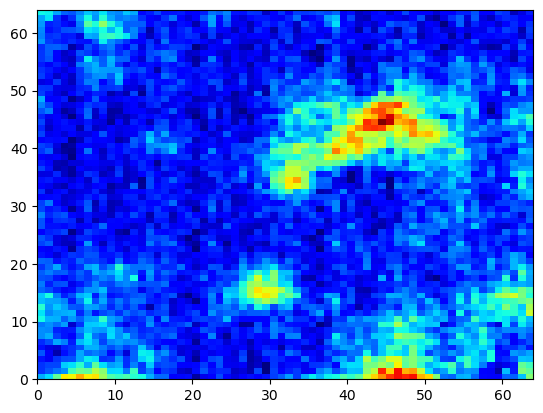

In [209]:
print(X_test[0,:,:,0].shape)
tb_test=X_test[0,:,:,0]*1.5*tbs+tbm
tb_deconv_linR=tb_test.copy()*0-99
tb_deconv_linRO=tb_test.copy()*0-99
for i in range(4):
    for j in range(4):
        xpred=tb_test[i*16:(i+1)*16,j*16:(j+1)*16]
        xpred=xpred[::3,:].flatten()
        ypred=reg3.predict(xpred.reshape(1,len(xpred)))[0,:]
        tb_deconv_linR[i*16:(i+1)*16,j*16:(j+1)*16]=ypred.reshape(16,16)
        xpred=tb_test[i*16:(i+1)*16,j*16:(j+1)*16]
        xpred=xpred[:,:].flatten()
        ypred=reg.predict(xpred.reshape(1,len(xpred)))[0,:]
        tb_deconv_linRO[i*16:(i+1)*16,j*16:(j+1)*16]=ypred.reshape(16,16)
        
plt.pcolormesh(tb_deconv_linR.T,cmap='jet',vmin=160,vmax=280)
y_pred3=tb_deconv_linR.copy()

In [221]:

tbL=[]
tb3L=[]
for i in range(X_test.shape[0]):
    tb_test=X_test[i,:,:,0]*1.5*tbs+tbm
    tb_deconv_linRO=tb_test.copy()*0-99
    tb_deconv_linR=tb_test.copy()*0-99
    for i in range(4):
        for j in range(4):
            xpred=tb_test[i*16:(i+1)*16,j*16:(j+1)*16]
            xpred=xpred[:,:].flatten()
            ypred=reg.predict(xpred.reshape(1,len(xpred)))[0,:]
            tb_deconv_linRO[i*16:(i+1)*16,j*16:(j+1)*16]=ypred.reshape(16,16)
            xpred=tb_test[i*16:(i+1)*16,j*16:(j+1)*16]
            xpred=xpred[::3,:].flatten()
            ypred=reg3.predict(xpred.reshape(1,len(xpred)))[0,:]
            tb_deconv_linR[i*16:(i+1)*16,j*16:(j+1)*16]=ypred.reshape(16,16)
    tbL.append(tb_deconv_linRO.copy())
    tb3L.append(tb_deconv_linR.copy())

In [ ]:

plt.pcolormesh(tb_deconv_linR.T,cmap='jet',vmin=160,vmax=280)

0.13898866957438524 0.2343495614596305
0.308651055390131


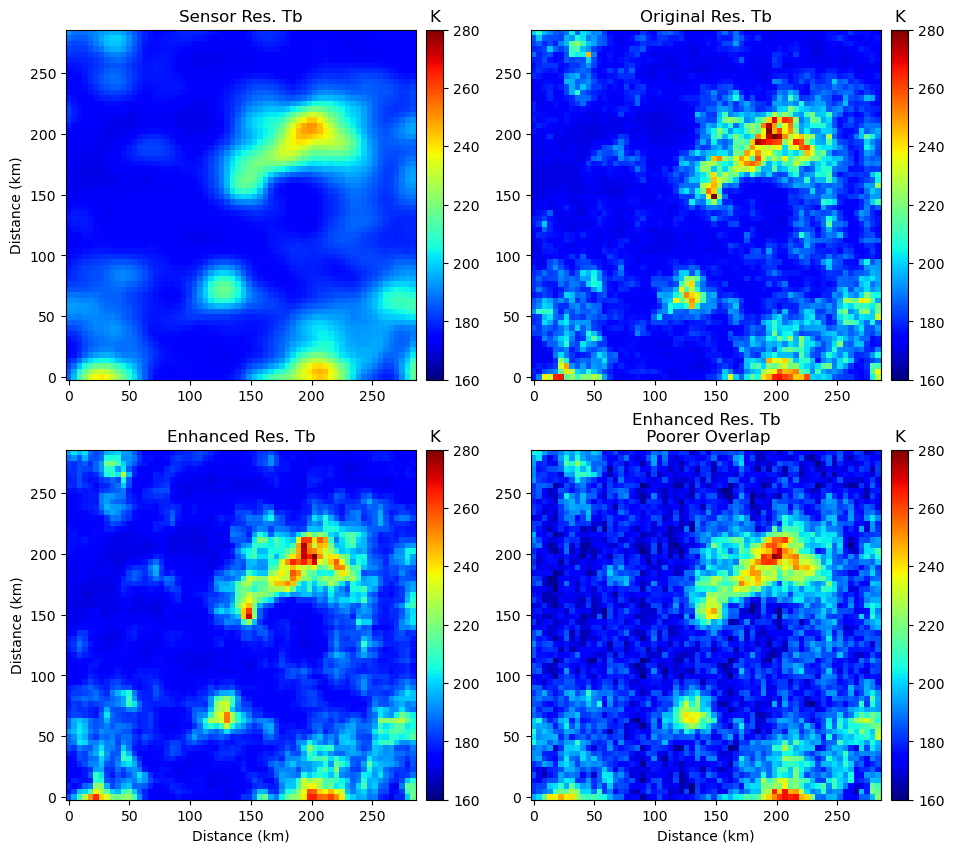

In [190]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.figure(figsize=(11,10))
x=np.arange(64)*4.5
y=np.arange(64)*4.5
ax1=plt.subplot(221)
c1=plt.pcolormesh(x,y,(1.5*tbs*X_test[0,:,:,0]+tbm).T,cmap='jet',vmin=160,vmax=280)
plt.ylabel('Distance (km)')
plt.title('Sensor Res. Tb')
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.1)
cb1=plt.colorbar(c1,cax=cax1)
plt.title('K')
ax1.set_aspect('equal')
ax2=plt.subplot(222)
c2=plt.pcolormesh(x,y,(1.5*tbs*y_test[0,:,:,0]+tbm).T,cmap='jet',vmin=160,vmax=280)
plt.title('Original Res. Tb')
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="5%", pad=0.1)
ax2.set_aspect('equal')
cb2=plt.colorbar(c2,cax=cax2)
plt.title('K')

ax3=plt.subplot(223)
c3=plt.pcolormesh(x,y,(1.5*tbs*y_pred[0,:,:,0]+tbm).T,cmap='jet',vmin=160,vmax=280)
ax3.set_aspect('equal')
divider = make_axes_locatable(ax3)
plt.xlabel('Distance (km)')
plt.ylabel('Distance (km)')
plt.title('Enhanced Res. Tb')
cax3 = divider.append_axes("right", size="5%", pad=0.1)
plt.title('K')
cb3=plt.colorbar(c3,cax=cax3)
ax4=plt.subplot(224)


plt.pcolormesh(x,y,y_pred3.T,cmap='jet',vmin=160,vmax=280)
plt.title('Enhanced Res. Tb\n Poorer Overlap')
ax4.set_xlabel('Distance (km)')
divider = make_axes_locatable(ax4)
cax4 = divider.append_axes("right", size="5%", pad=0.1)
ax4.set_aspect('equal')
plt.colorbar(cax=cax4)
plt.title('K')
y_pred3_sc=(y_pred3-tbm)/1.5/tbs
print(np.abs(y_test[0,:,:,0]-y_pred[0,:,:,0]).mean(),np.abs(y_test[0,:,:,0]-X_test[0,:,:,0]).mean())
print(np.abs(y_test[0,:,:,0]-y_pred3_sc[:,:]).mean())

plt.savefig('DeConvolution_2_10GHz.png',dpi=300,bbox_inches='tight')

(64, 64)
(1500, 64, 64, 1)
(1500, 64, 64)
(1500, 64, 64, 1)


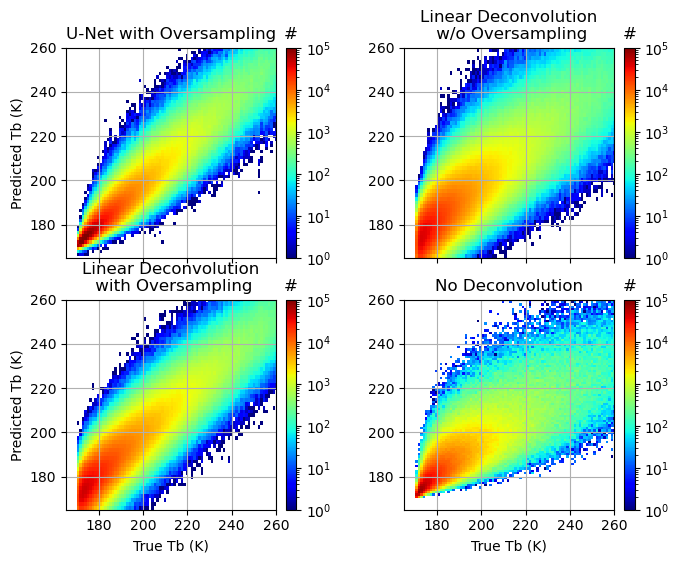

In [244]:
y_pred3=tb_deconv_linR.copy()
plt.figure(figsize=(8,6))
ax1=plt.subplot(221)
h1=plt.hist2d(1.5*tbs*y_test[:,:,:].flatten()+tbm,1.5*tbs*y_pred[:,:,:].flatten()+tbm,bins=100,cmap='jet',norm=matplotlib.colors.LogNorm(vmin=1,vmax=1e5))
ax1.set_aspect('equal')
plt.xlim(165,260)
plt.ylim(165,260)
plt.ylabel('Predicted Tb (K)')
#ax1.set_xlabel([])
ax1.set_xticklabels([])
plt.grid()
plt.title('U-Net with Oversampling')

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.1)
plt.title('#')
cb1=plt.colorbar(h1[-1],cax=cax1)

ax2=plt.subplot(222)
print(y_pred3.shape)
print(y_test.shape)
y_pred3=tb_deconv_linRO
y_pred3=np.array(tb3L)
h2=plt.hist2d(1.5*tbs*y_test[:,:,:].flatten()+tbm,y_pred3.flatten(),bins=100,cmap='jet',norm=matplotlib.colors.LogNorm(vmin=1,vmax=1e5))
plt.grid()
#plt.xlabel('Predicted Tb (K)')
ax2.set_aspect('equal')
ax2.set_xticklabels([])

plt.xlim(165,260)
plt.ylim(165,260)
plt.title('Linear Deconvolution\n w/o Oversampling')
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="5%", pad=0.1)
plt.title('#')
cb1=plt.colorbar(h2[-1],cax=cax2)

ax3=plt.subplot(223)
print(y_pred3.shape)
print(y_test.shape)
y_pred3=tb_deconv_linRO
y_pred3=np.array(tbL)
h3=plt.hist2d(1.5*tbs*y_test[:,:,:].flatten()+tbm,y_pred3.flatten(),bins=100,cmap='jet',norm=matplotlib.colors.LogNorm(vmin=1,vmax=1e5))
plt.grid()

ax3.set_aspect('equal')
plt.xlim(165,260)
plt.ylim(165,260)
plt.title('Linear Deconvolution\n with Oversampling')
plt.ylabel('Predicted Tb (K)')
plt.xlabel('True Tb (K)')
divider = make_axes_locatable(ax3)
cax3 = divider.append_axes("right", size="5%", pad=0.1)
plt.title('#')
cb3=plt.colorbar(h3[-1],cax=cax3)

ax4=plt.subplot(224)
h4=plt.hist2d(1.5*tbs*y_test[:,:,:].flatten()+tbm,1.5*tbs*X_test[:,:,:].flatten()+tbm,bins=100,cmap='jet',norm=matplotlib.colors.LogNorm(vmin=1,vmax=1e5))
ax4.set_aspect('equal')
plt.xlim(165,260)
plt.ylim(165,260)
plt.grid()

ax4.set_aspect('equal')
plt.xlim(165,260)
plt.ylim(165,260)
plt.title('No Deconvolution')
plt.xlabel('True Tb (K)')
divider = make_axes_locatable(ax4)
cax4 = divider.append_axes("right", size="5%", pad=0.1)
plt.title('#')
cb4=plt.colorbar(h4[-1],cax=cax4)

plt.savefig('UNet_vs_Regr3.png',dpi=300,bbox_inches='tight')

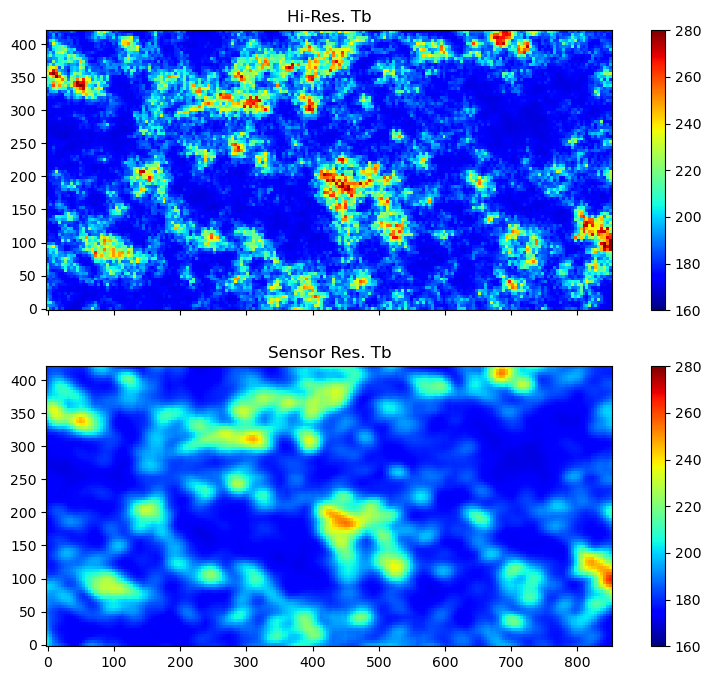

In [36]:
seed_value=19780938
attKuCoeff=(1.08783315, -3.61981317)
from scipy.signal import convolve2d 

gainField=np.zeros((7,5))
for i in range(7):
    for j in range(5):
        gainField[i,j]=np.exp(-4*np.log(2)*(((i-3)*4.5)**2/32**2+((j-2)*4.5)**2/19**2))

gainField=gainField/gainField.sum()
def simTb(seed_value,attKuCoeff):
    srf = SRF(fit_model, seed=seed_value)
    x_s, y_s = range(2*98),range(2*49)
    new_logR = srf((x_s, y_s), mesh_type='structured')
    genRainField=np.exp(new_logR-1.25)*6.5
    attKu=np.exp(attKuCoeff[0]*np.log(genRainField)+attKuCoeff[1])*9
    tb=282-np.exp((attKu-20.043)/(-4.247))
    tb2dConv=convolve2d(tb, gainField, mode='valid')
    return tb2dConv,tb,genRainField

tb2dConv_2,tb_2,genRainField_2=simTb(seed_value,attKuCoeff)

plt.figure(figsize=(10,8))
ax1=plt.subplot(212)
c1=ax1.pcolormesh(np.arange(190)*4.5,np.arange(94)*4.5,tb2dConv_2.T,cmap='jet',vmin=160,vmax=280)
ax1.set_aspect('equal')
plt.title('Sensor Res. Tb')
plt.colorbar(c1)
ax2=plt.subplot(211)
c2=ax2.pcolormesh(np.arange(190)*4.5,np.arange(94)*4.5,tb_2[3:-3,2:-2].T,cmap='jet',vmin=160,vmax=280)
plt.title('Hi-Res. Tb')
ax2.set_aspect('equal')
ax2.set_xticklabels([])
plt.colorbar(c2)
plt.savefig('Tb.png',dpi=300,bbox_inches='tight')

(190, 94)
(190, 94)
(196, 98)
[[1.         0.87403569]
 [0.87403569 1.        ]]


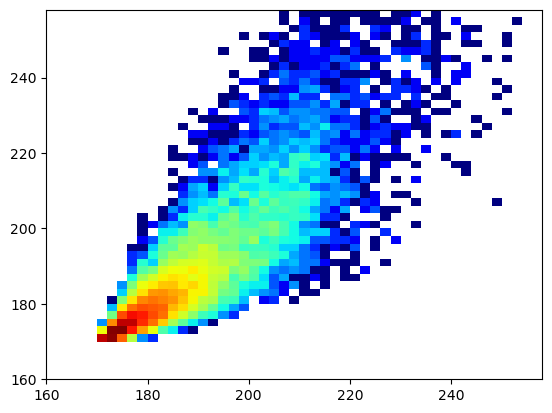

In [35]:
from skimage import color, data, restoration
import matplotlib.colors
tb_deconv=tb2dConv_2.copy()
print(tb_deconv.shape)
print(tb2dConv_2.shape)
print(convolve2d(tb_deconv, gainField, mode='full').shape)
print(np.corrcoef(tb2dConv_2.flatten(),tb_2[3:-3,2:-2].flatten()))
hist=plt.hist2d(tb2dConv_2.flatten(),tb_2[3:-3,2:-2].flatten(),bins=160+np.arange(50)*2,cmap='jet',norm=matplotlib.colors.LogNorm())
#for i in range(5):
#    tb_deconv=tb_deconv+(tb2dConv_2-convolve2d(tb_deconv, gainField, mode='full')[3:-3,2:-2])

#plt.pcolormesh(np.arange(190)*4.5,np.arange(94)*4.5,tb_deconv[:,:].T,cmap='jet',vmin=160,vmax=280)
